# Importing major libraries

In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from scipy import signal
from typing import Dict, List, Tuple, Optional
import warnings as wr
wr.filterwarnings('ignore')

# Importing the dataset

In [4]:
df1 = pd.read_csv('Turbine_1.csv',low_memory=False)
df2 = pd.read_csv('Turbine_2.csv',low_memory=False)

In [5]:
df2['t'] = pd.to_datetime(df1['t'], errors='coerce') # Converts the timestamps to Time Dela
df2['t'] = pd.to_datetime(df2['t'], errors='coerce') # Converts the timestamps to Time Dela

# Variable used in the Analysis

In [7]:
# Variables to be defined for spectral analysis
fs = 62.5                # Sampling Frequency 
hp_cut_hz = 0.1          # high-pass cutoff to remove gravity/drift. 
                     # It is assumed that the wind turbine is rotating at least 6 rpm(6/60 = 0.1Hz)
hp_order = 2
detrend = "linear" 
nperseg_sec = 20.0      # segment length (s)
noverlap_ratio = 0.5     # 50% overlap
window = "hann"
average = "mean"
scaling = "density"        # 'density' (PSD) or 'spectrum'

# Variable to be used for finding peak and modes of vibration
fmin_1p: float = 0.1            # Below 0.1Hz are already filtered using Buttress filter
fmax_1p: float = 2.0            # most rotors < 2 Hz 
min_prominence_db = 6.0  # prominence in dB for peak acceptance

# Mode search
fmin_mode: float = 0.2
fmax_mode: float = 31.0         # Nyquist ~31.25 at fs=62.5
max_modes: int = 4

# Filter to remove effect of gravity. It is assumed that wind turbine is rotating at atleast 6 rpm

In [9]:
# Filter to remove effect of gravity. It is assumed that wind turbine is rotating at atleast 6 rpm
def butter_highpass(x: np.ndarray, fs: float, hp_cut_hz: float, hp_order: int = 2) -> np.ndarray:
    '''Buttress filter to remove the effect of gravity. Here, a high pass filter is used.'''
    if hp_cut_hz <= 0:
        return x.copy()
    b, a = signal.butter(hp_order, hp_cut_hz / (0.5 * fs), btype='highpass')
    return signal.filtfilt(b, a, x)

# Detrending the series
def preprocess_series(x: np.ndarray, type: str, fs: float, hp_cut_hz: float, hp_order: int) -> np.ndarray:
    ''' Function to detrend and remove high frequencies
    Input: An array of vibration signals from each channel
    Output: An array of filtered signal'''
    # Detrend first (helps with HPF transients)
    x_dt = signal.detrend(x, type = detrend) 
    return butter_highpass(x_dt, fs, hp_cut_hz, hp_order)

# Functions to calculate power spectral density (PSD)

In [11]:
# Function Welch PSD 
def welch_psd(x: np.ndarray, fs: float, nperseg_sec: float, noverlap_ratio: float, 
              window: str, average: str, scaling: str) -> Tuple[np.ndarray, np.ndarray]:
    """ Welch PSD is used instead of FFT to  reduces the variance of the estimate"""
    nperseg = int(max(8, round(nperseg_sec * fs)))
    noverlap = int(round(noverlap_ratio * nperseg))
    f, Pxx = signal.welch(
        x, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap,
        average=average, scaling=scaling, detrend = "constant"
    )
    return f, Pxx
    

# Function for Coherence Analysis
def coherence(x: np.ndarray, y: np.ndarray, fs: float, nperseg_sec: float, 
              noverlap_ratio: float, window: str) -> Tuple[np.ndarray, np.ndarray]:
    """Calculates coherence between two signals"""
    nperseg = int(max(8, round(nperseg_sec * fs)))
    noverlap = int(round(noverlap_ratio * nperseg))
    f, Cxy = signal.coherence(x, y, fs=fs, window=window,
                              nperseg=nperseg_sec, noverlap=noverlap_ratio, detrend="constant")
    return f, Cxy



In [12]:
# Function for Magnitude to Decibel Conversion
def mag2db(x: np.ndarray, eps: float = 1e-20) -> np.ndarray:
    return 10.0 * np.log10(np.maximum(x, eps))

In [13]:
# Function to find peaks
def find_peak_in_band(f: np.ndarray, pxx: np.ndarray, fmin: float, fmax: float,
                      min_prom_db: float = 6.0) -> Optional[Tuple[float, float]]:
    """Return (f_peak, amp_linear) or None if not found. The idea here is to find the peak of vibration.
    If the natural frequency of vibration decreases, it may be due to loss of stiffness due to failure
    of blade, erosion or increase in the weight of blade due to snow or water ingress"""
    band = (f >= fmin) & (f <= fmax)
    if not np.any(band):
        return None
    fb, pb = f[band], pxx[band]
    # Use prominence on dB scale
    y = mag2db(pb)
    # Dynamic prominence threshold relative to local median
    baseline = np.median(y)
    prom = max(min_prom_db, 0.0)
    peaks, props = signal.find_peaks(y, prominence=prom)
    if peaks.size == 0:
        # Try relative threshold
        peaks, props = signal.find_peaks(y, height=baseline + prom)
        if peaks.size == 0:
            return None
    idx = peaks[np.argmax(y[peaks])]
    return float(fb[idx]), float(pb[idx])

In [14]:
# Function to find the peak modes to analyse the dominant mode of vibration
def cross_spectral_matrix(X: np.ndarray, fs: float, nperseg_sec: float, noverlap_ratio: float = 0.5):
    """
    Compute frequency-dependent cross-spectral matrix S_xx(f) of shape (n_f, n_ch, n_ch).
    """
    nperseg = max(8, int(round(nperseg_sec*fs)))
    noverlap = int(round(noverlap_ratio*nperseg))
    f, Pxx = signal.welch(X, fs=fs, window="hann", nperseg=nperseg, noverlap=noverlap,
                          detrend="constant", axis=0, scaling="density", return_onesided=True)
    # Use csd for off-diagonals
    n_f = len(f)
    n_ch = X.shape[1]
    S = np.zeros((n_f, n_ch, n_ch), dtype=complex)
    for i in range(n_ch):
        for j in range(i, n_ch):
            if i == j:
                S[:, i, j] = Pxx[:, i]
            else:
                f2, Pij = signal.csd(X[:, i], X[:, j], fs=fs, window="hann",
                                     nperseg=nperseg, noverlap=noverlap, detrend="constant",
                                     scaling="density")
                S[:, i, j] = Pij
                S[:, j, i] = np.conj(Pij)
    return f, S

def peak_pick_from_singular_values(f: np.ndarray, s1: np.ndarray, fmin: float, fmax: float, prom_db: float = 6.0, max_peaks: int = 6) -> List[float]:
    band = (f >= fmin) & (f <= fmax)
    if not np.any(band):
        return []
    fb = f[band]
    y = mag2db(s1[band])
    peaks, props = signal.find_peaks(y, prominence=prom_db, distance=max(1, int(0.2 / (fb[1]-fb[0]))))
    if peaks.size == 0:
        return []
    prom = props.get("prominences", np.zeros_like(peaks))
    order = np.argsort(prom)[::-1]
    modes = [float(fb[p]) for p in peaks[order][:max_peaks]]
    modes.sort()
    return modes

In [15]:
# Function to find how much vibration is transferred from the tip to the roots
def transmissibility(pxx_tip: np.ndarray, pxx_root: np.ndarray) -> np.ndarray:
    """ Returns Vibration Transmissibility (or Frequency Response Ratio)
        Transmissibility = Output PSD ÷ Input PSD"""
    eps = 1e-20
    return (pxx_tip + eps) / (pxx_root + eps)


In [16]:
# simple linear interpolation
def interp(arrf, arrv, f0):
        if np.isnan(f0) or f0 < arrf[0] or f0 > arrf[-1]:
            return float("nan")
        return float(np.interp(f0, arrf, arrv))

# Welch PSD for Turbine 1 and Turbine 2

In [18]:
# Build channel names
psd_dict = {}
axes = ["edge", "span", "flap"]
blade = [1,2,3]
for i in blade:
    for loc in ["root", "tip"]:
        for ax in axes:
            name = f"B{i}_{loc}_{ax}"
            z = df1[name].to_numpy(dtype=float)
            y = preprocess_series(z, fs=fs, hp_cut_hz= hp_cut_hz, hp_order=hp_order, type=detrend)
            f, Pxx = welch_psd(y, fs = fs, nperseg_sec = nperseg_sec, noverlap_ratio = noverlap_ratio,
                               window = window, average = average, scaling = scaling)
            z1 = df2[name].to_numpy(dtype=float)
            y1 = preprocess_series(z1, fs=fs, hp_cut_hz= hp_cut_hz, hp_order=hp_order, type=detrend)
            f1, Pxx1 = welch_psd(y1, fs = fs, nperseg_sec = nperseg_sec, noverlap_ratio = noverlap_ratio,
                               window = window, average = average, scaling = scaling)
            psd_dict[name] = [(f, Pxx), (f1, Pxx1)]


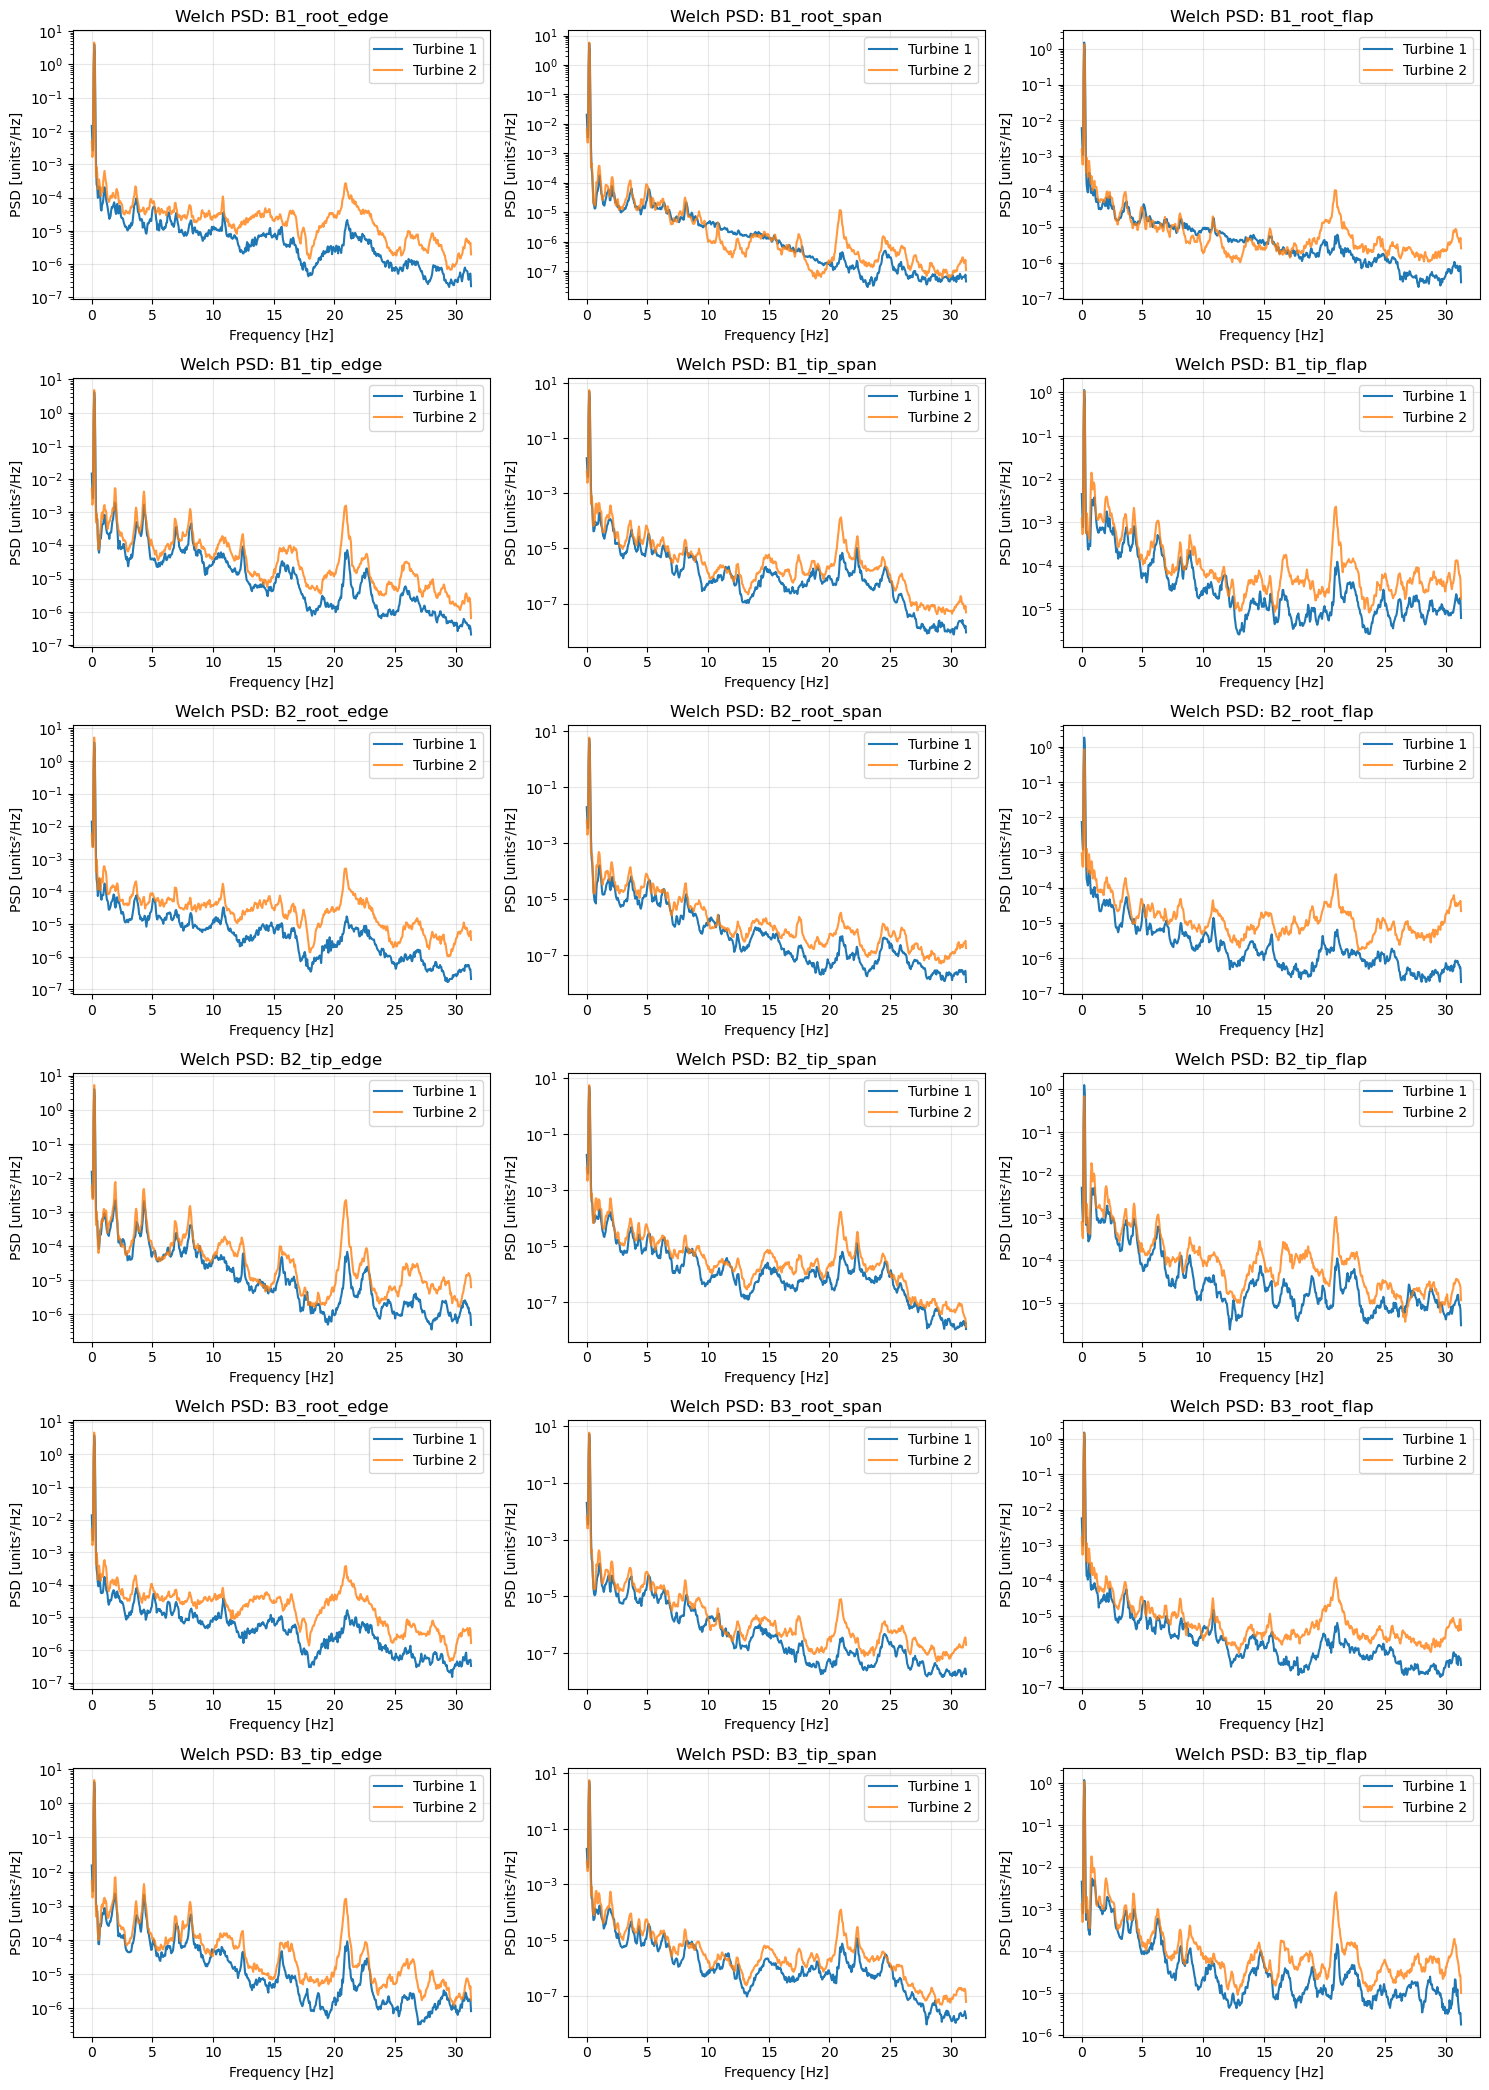

In [19]:
# Welch PSD curves for D (two datasets overlaid per channel)
max_plots_per_row = 3  # was ax_plots_per_row

if psd_dict:
    n = len(psd_dict)
    ncols = min(max_plots_per_row, n)
    nrows = int(np.ceil(n / ncols))

    fig, axes = plt.subplots(
        nrows, ncols,
        figsize=(5 * ncols, 3.5 * nrows),
        squeeze=False,
        sharex=False, sharey=False  # set True/True if you want common scales
    )
    flat_axes = axes.ravel()

    for i, (key, two_psds) in enumerate(psd_dict.items()):
        ax = flat_axes[i]
        # Unpack your two PSDs
        (f0, Pxx0), (f1, Pxx1) = two_psds

        ax.semilogy(f0, Pxx0, label="Turbine 1",alpha=1)
        ax.semilogy(f1, Pxx1, label="Turbine 2",alpha=0.8)

        ax.set_title(f"Welch PSD: {key}")
        ax.set_xlabel("Frequency [Hz]")
        ax.set_ylabel("PSD [units²/Hz]")
        ax.grid(True, alpha=0.3)
        ax.legend(loc="best")

    # Hide any unused axes
    total = nrows * ncols
    for j in range(n, total):
        fig.delaxes(flat_axes[j])

    fig.tight_layout()
    plt.show()


# Coherence Analysis for Turbine 1 and Turbine 2

In [21]:
# Build channel names
csd_dict = {}
Coh_1p_T1 = {}
Coh_1p_T2 = {}
col = list()
axes = ["edge", "span", "flap"]
fsd = psd_dict['B1_root_edge'][0][0]
blade = [1]       # Create input for the Dashboard
for i in blade:
    for loc in ["root", "tip"]:
        for ax in axes:
            name = f"B{i}_{loc}_{ax}"
            col.append(name)

pairs = list(itertools.combinations(col, 2))
for i, (col1, col2) in enumerate(pairs):
    z1 = df1[col1].to_numpy(dtype=float)
    x = preprocess_series(z1, fs=fs, hp_cut_hz= hp_cut_hz, hp_order=hp_order, type=detrend)
    z2 = df1[col2].to_numpy(dtype=float)
    y = preprocess_series(z2, fs=fs, hp_cut_hz= hp_cut_hz, hp_order=hp_order, type=detrend)
    z3 = df2[col1].to_numpy(dtype=float)
    x1 = preprocess_series(z3, fs=fs, hp_cut_hz= hp_cut_hz, hp_order=hp_order, type=detrend)
    z4 = df2[col2].to_numpy(dtype=float)
    y1 = preprocess_series(z4, fs=fs, hp_cut_hz= hp_cut_hz, hp_order=hp_order, type=detrend)
    f, Cxy = coherence(x, y, fs = fs, nperseg_sec = nperseg_sec, noverlap_ratio = noverlap_ratio,
                       window = window)
    Coh_1p_T1[(col1,col2)] = interp(f,Cxy,0.20833333333333334)
    f1, Cxy1 = coherence(x1, y1, fs = fs, nperseg_sec = nperseg_sec, noverlap_ratio = noverlap_ratio,
                       window = window)
    Coh_1p_T2[(col1,col2)] = interp(f1,Cxy1,0.20833333333333334)
    csd_dict[(col1,col2)] =  [(f, Cxy), (f1, Cxy1)]


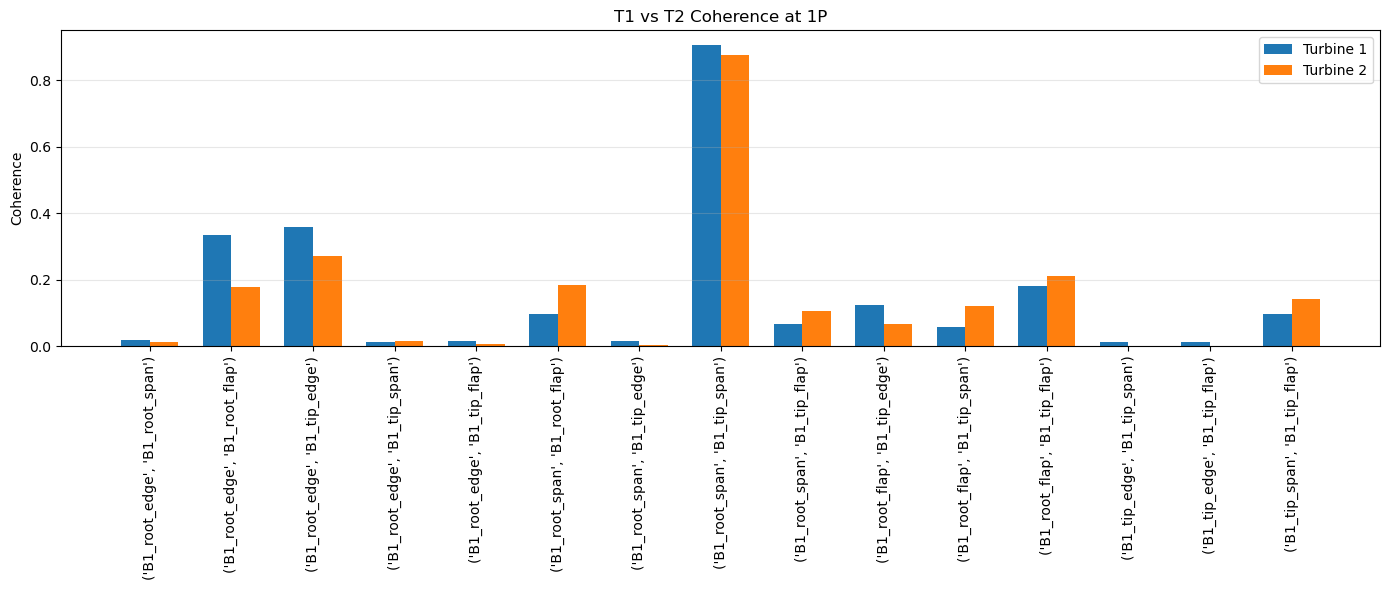

In [22]:
df_1 = pd.DataFrame.from_dict(Coh_1p_T1, orient='index',columns=['T1_Coh_1P'])
df_2 = pd.DataFrame.from_dict(Coh_1p_T2, orient='index',columns=['T2_Coh_1P'])
df = pd.concat([df_1,df_2],axis=1)
# Plot for increase in amplitudes at first harmonic
x = np.arange(len(df))
width = 0.35

plt.figure(figsize=(14, 6))
plt.bar(x - width/2, df["T1_Coh_1P"], width, label="Turbine 1")
plt.bar(x + width/2, df["T2_Coh_1P"], width, label="Turbine 2")

plt.xticks(x, df.index, rotation=90)
plt.ylabel("Coherence")
plt.title("T1 vs T2 Coherence at 1P")
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

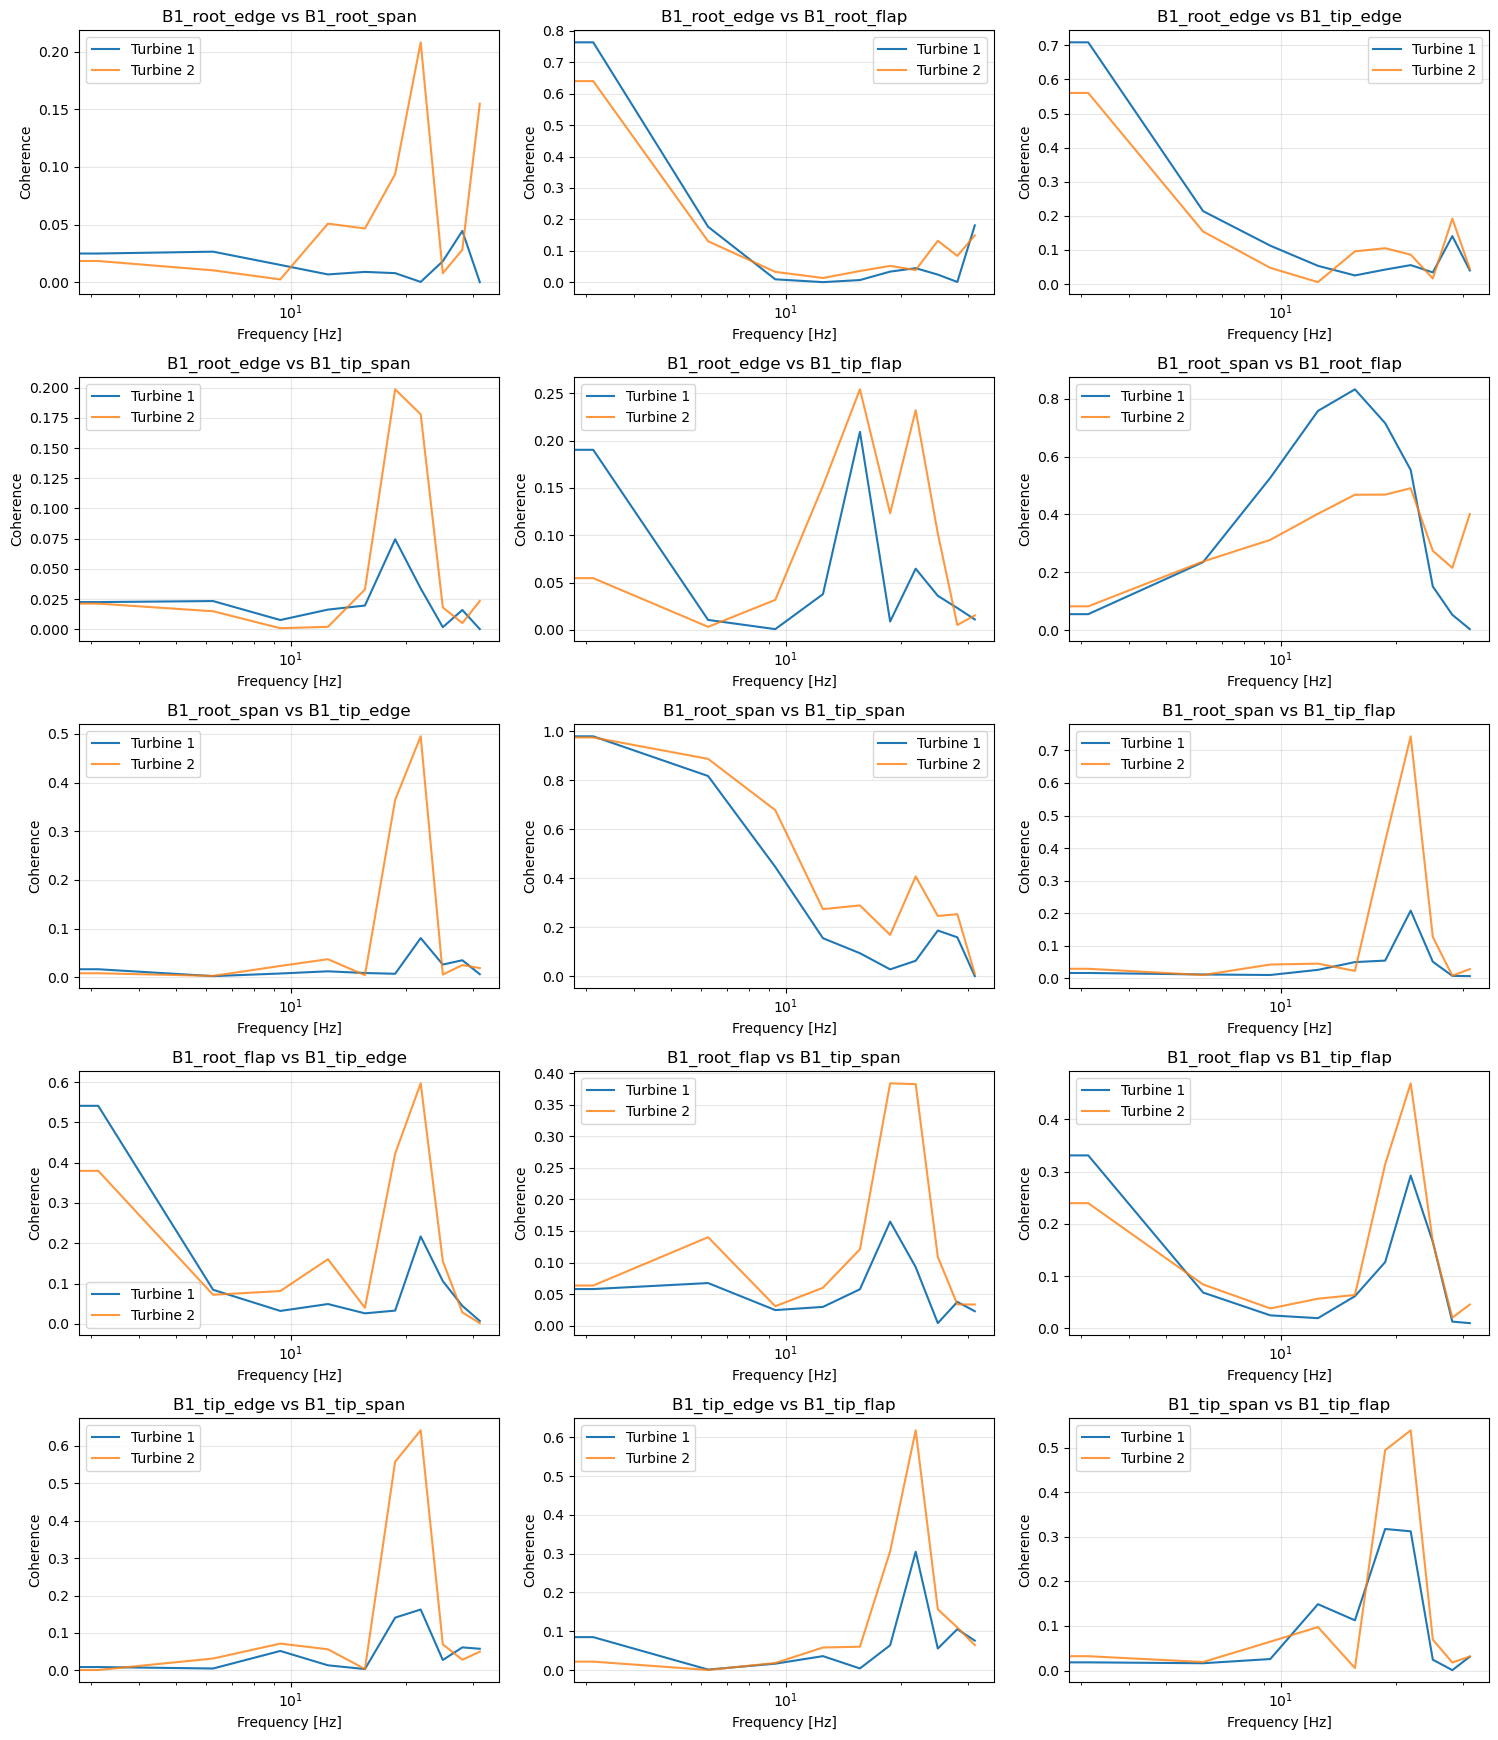

In [23]:
# Welch PSD curves for Coherence
max_plots_per_row = 3  # was ax_plots_per_row

if csd_dict:
    n = len(csd_dict)
    ncols = min(max_plots_per_row, n)
    nrows = int(np.ceil(n / ncols))

    fig, axes = plt.subplots(
        nrows, ncols,
        figsize=(5 * ncols, 3.5 * nrows),
        squeeze=False,
        sharex=False, sharey=False  # set True/True if you want common scales
    )
    flat_axes = axes.ravel()

    for i, (key, two_psds) in enumerate(csd_dict.items()):
        ax = flat_axes[i]
        # Unpack your two PSDs
        (f0, Cxy0), (f1, Cxy1) = two_psds

        ax.semilogx(f0, Cxy0, label="Turbine 1",alpha=1)
        ax.semilogx(f1, Cxy1, label="Turbine 2",alpha=0.8)

        ax.set_title(f"{key[0]} vs {key[1]}")
        ax.set_xlabel("Frequency [Hz]")
        ax.set_ylabel("Coherence")
        ax.grid(True, alpha=0.3)
        ax.legend(loc="best")

    # Hide any unused axes
    total = nrows * ncols
    for j in range(n, total):
        fig.delaxes(flat_axes[j])

    fig.tight_layout()
    plt.show()


# Finding Peak 

In [25]:
peak_T1 = {}
peak_T2 = {}
for key,value in psd_dict.items():
    peak_T1[key] = find_peak_in_band(f= psd_dict[key][0][0],pxx = psd_dict[key][0][1],
                                  fmin = fmin_1p, fmax = fmax_1p, min_prom_db = min_prominence_db)
    peak_T2[key] = find_peak_in_band(f= psd_dict[key][1][0],pxx = psd_dict[key][1][1],
                                  fmin = fmin_1p, fmax = fmax_1p, min_prom_db = min_prominence_db)

df_1 = pd.DataFrame.from_dict(peak_T1, orient='index',columns=['T1_F1P', 'T1_amplitude'])
df_2 = pd.DataFrame.from_dict(peak_T2, orient='index',columns=['T2_F1P', 'T2_amplitude'])
df = pd.concat([df_1,df_2],axis=1)

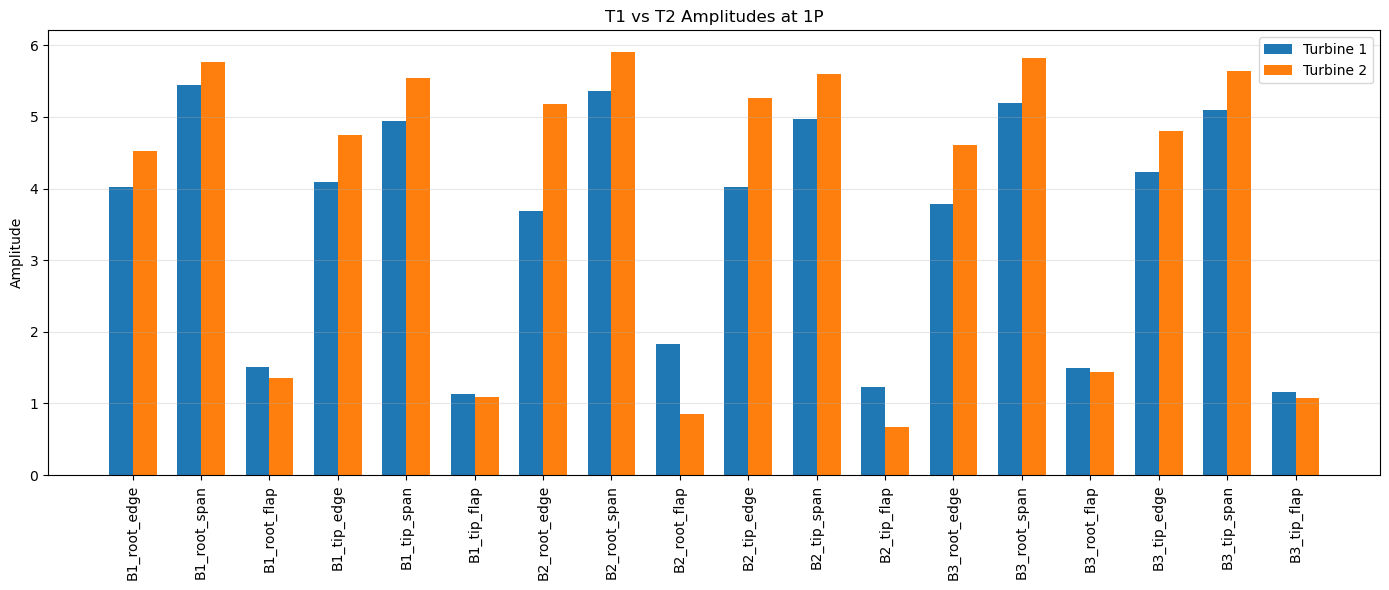

In [26]:
# Plot for increase in amplitudes at first harmonic
x = np.arange(len(df))
width = 0.35

plt.figure(figsize=(14, 6))
plt.bar(x - width/2, df["T1_amplitude"], width, label="Turbine 1")
plt.bar(x + width/2, df["T2_amplitude"], width, label="Turbine 2")

plt.xticks(x, df.index, rotation=90)
plt.ylabel("Amplitude")
plt.title("T1 vs T2 Amplitudes at 1P")
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# Transmissibility

In [28]:
trans_t1 = []
t1_psd = []
t2_psd = []
trans_t2 = []
trans_col = []
axes = ["edge", "span", "flap"]
fsd = psd_dict['B1_root_edge'][0][0]
for i in range(0, len(pairs)-1):
    for ax in axes:
        if ax in pairs[i][0] and ax in pairs[i][1]:
            trans_col.append(pairs[i])
for i in trans_col:
    t = transmissibility(psd_dict[i[1]][0][1],psd_dict[i[0]][0][1])
    t1_psd.append(t)
    inter = interp(fsd,t,0.20833333333333334)
    trans_t1.append(inter)
    t = transmissibility(psd_dict[i[1]][1][1],psd_dict[i[0]][1][1])
    t2_psd.append(t)
    inter = interp(fsd,t,0.20833333333333334)
    trans_t2.append(inter)

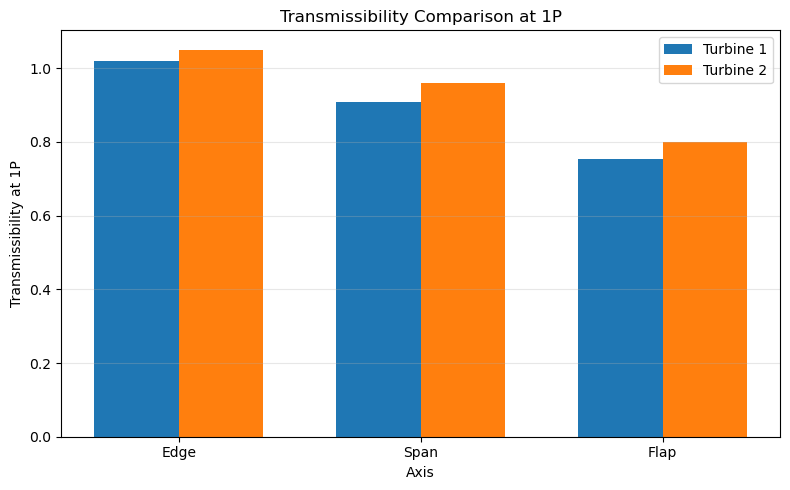

In [29]:
# Comparison of Transmissibility for Turbine 1 and Turbine 2
labels = ["Edge", "Span", "Flap"]

x = np.arange(len(labels))  
width = 0.35                

plt.figure(figsize=(8, 5))

# Plot bars
plt.bar(x - width/2, trans_t1, width, label="Turbine 1")
plt.bar(x + width/2, trans_t2, width, label="Turbine 2")

# Axis labeling
plt.xticks(x, labels)
plt.xlabel("Axis")
plt.ylabel("Transmissibility at 1P")
plt.title("Transmissibility Comparison at 1P")

plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


# Transmissibility PSD

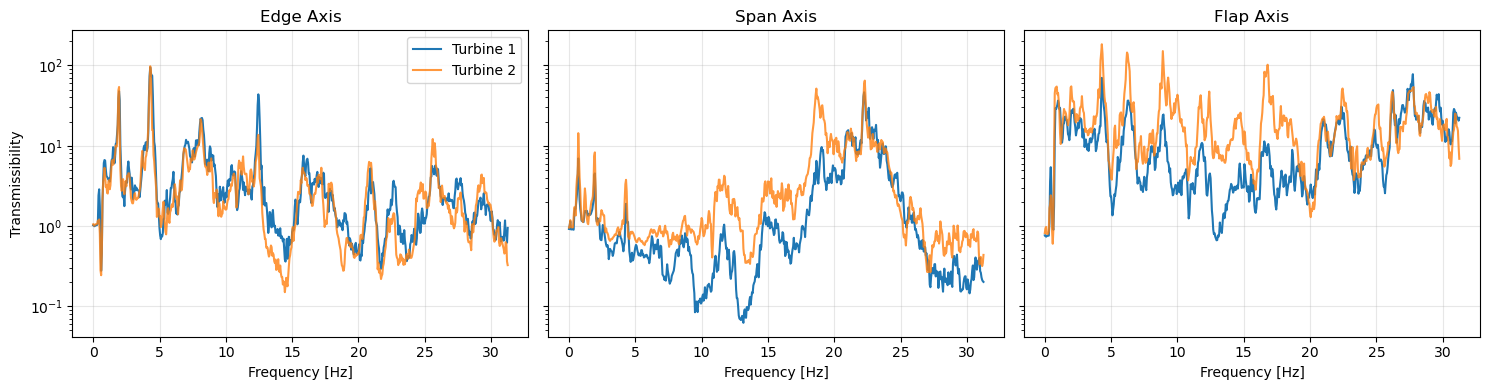

In [31]:

labels = ["edge", "span", "flap"]   # axis order
indices = [0, 1, 2]                 # matching indices in t1_psd / t2_psd

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=True, sharey=True)

for ax, lab, idx in zip(axes, labels, indices):
    ax.semilogy(fsd, t1_psd[idx], label="Turbine 1")
    ax.semilogy(fsd, t2_psd[idx], alpha=0.8, label="Turbine 2")

    ax.set_title(f"{lab.capitalize()} Axis")
    ax.set_xlabel("Frequency [Hz]")
    ax.grid(True, alpha=0.3)

axes[0].set_ylabel("Transmissibility")
axes[0].legend()

plt.tight_layout()
plt.show()


# Frequency Domain Decomposition

In [33]:
mode = {}

AXES = ["edge", "span", "flap"]
LOCATIONS = ["root", "tip"]

for blade in [1, 2, 3]:
    ch_names = []
    data_cols_1 = []
    data_cols_2 = []

    for loc in LOCATIONS:
        for ax in AXES:
            name = f"B{blade}_{loc}_{ax}"
            ch_names.append(name)
            data_cols_1.append(df1[name].to_numpy(dtype=float))
            data_cols_2.append(df2[name].to_numpy(dtype=float))

    X = np.vstack(data_cols_1).T   
    Y = np.vstack(data_cols_2).T   

    f_psd, S = cross_spectral_matrix(X, fs, nperseg_sec, noverlap_ratio)
    n_f = len(f_psd)
    s1 = np.zeros(n_f)

    for k in range(n_f):
        U, s, Vh = np.linalg.svd(S[k, :, :])
        s1[k] = s[0].real

    mode[f"T1_B{blade}"] = peak_pick_from_singular_values(
        f_psd, s1, fmin_mode, fmax_mode, min_prominence_db, max_peaks=8
    )

    f_psd, S = cross_spectral_matrix(Y, fs, nperseg_sec, noverlap_ratio)
    n_f = len(f_psd)
    s1 = np.zeros(n_f)

    for k in range(n_f):
        U, s, Vh = np.linalg.svd(S[k, :, :])
        s1[k] = s[0].real

    mode[f"T2_B{blade}"] = peak_pick_from_singular_values(
        f_psd, s1, fmin_mode, fmax_mode, min_prominence_db, max_peaks=8
    )

df_mode = pd.DataFrame.from_dict(mode, orient="index",
                                 columns=['Mode 1','Mode 2','Mode 3','Mode 4','Mode 5','Mode 6','Mode 7','Mode 8'])
df_mode.index.name = "Turbine_Blade"
df_mode

,Mode 1,Mode 2,Mode 3,Mode 4,Mode 5,Mode 6,Mode 7,Mode 8
Turbine_Blade,,,,,,,,
T1_B1,1.05,4.30,6.25,8.20,12.45,16.60,21.05,24.85
T2_B1,0.80,4.30,6.30,8.10,8.90,12.45,16.65,20.95
T1_B2,1.05,4.30,6.30,8.20,12.50,14.70,21.05,26.95
T2_B2,0.80,1.95,4.30,6.30,8.10,14.65,16.60,20.95
T1_B3,1.05,4.30,6.25,8.15,14.75,19.00,21.05,28.70
T2_B3,0.80,1.95,4.30,6.25,8.10,14.60,16.45,20.95
